# Figure 17

In [2]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, processes=False)
client

/storage1/home1/chiaweih/anaconda2/envs/python3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: scheduler='inproc://128.196.236.68/27375/1' processes=1 cores=8>

In [3]:
import warnings
warnings.simplefilter("ignore")

from mem_track import used_memory
used_memory()

used 137.230469 MB


In [4]:
used_memory()

used 137.253906 MB


# Model

In [5]:
#### possible input info from external text file
# constant setting
syear = 1993           
fyear = 2007

tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['tauuo','tauvo','zos','tos']
Area_name = ['areacello_cu','areacello_cv','areacello','areacello']

Model_name = ['JRA','CORE']
Model_legend_name = ['JRA55-do','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_tauuo.zarr'],['JRA_tauvo.zarr'],['JRA_zos.zarr'],['JRA_tos.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_tauuo.zarr'],['CORE_tauvo.zarr'],['CORE_zos.zarr'],['CORE_tos.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [6]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}
linear_mlist = {}

In [7]:
from xr_ufunc import da_linregress

#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear)&\
                                 (ds_model['time.year'] <= fyear)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist[model] = linear_list
    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRA tauuo
read JRA tauvo
read JRA zos
read JRA tos
read CORE tauuo
read CORE tauvo
read CORE zos
read CORE tos


In [8]:
# detrend 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        da_time = ds_model_mlist[model][var].time.copy()
        year = ds_model_mlist[model][var]['time.year'].values
        month = ds_model_mlist[model][var]['time.month'].values
        da_time.values = year+month/12.
        ds_model_mlist[model][var] = ds_model_mlist[model][var]-\
                                     (da_time*linear_mlist[model][var]['slope']+linear_mlist[model][var]['intercept'])

In [9]:
used_memory()

used 5491.519531 MB


# Observation

In [10]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1950,2011],[1993,2018,9]]


# standard model (interpolated to this model)
Model_standard = 'JRA'
tp_lat_region = [-30,30]     # extract model till latitude

Obs_varname = [['tx','ty'],['adt']]

Obs_name = ['WESwind','CMEMS']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/WASWind/'
obsfile = [['waswind_v1_0_1.monthly.nc'],['waswind_v1_0_1.monthly.nc']]
obspath[obs]=[obsdir,obsfile]

obs = Obs_name[1]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/CMEMS/'
obsfile = [['dt_global_allsat_phy_l4_monthly_adt.nc']]
obspath[obs]=[obsdir,obsfile]


for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [11]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist = {}
obs_mean_mlist = {}
obs_season_mlist = {}
obs_linear_mlist = {}

In [12]:
import spherical_area as sa

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    obs_linear_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/da_area.sum(dim=['longitude','latitude'])
            ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        # crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear)&\
                                 (ds_obs['time.year'] <= fyear)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
        # calculate mean 
        obs_mean_list[var] = ds_obs_list[var].mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
        # calculate seasonality
        obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]
        
        # remove linear trend 
        obs_linear_list[var] = da_linregress(ds_obs_list[var].load(),xname='lon',yname='lat',stTconfint=0.99,skipna=True) 

    obs_linear_mlist[obs] = obs_linear_list
    obs_mean_mlist[obs] = obs_mean_list
    obs_season_mlist[obs] = obs_season_list
    ds_obs_mlist[obs] = ds_obs_list

read WESwind tx
read WESwind ty
read CMEMS adt


In [13]:
# detrend 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        da_time = ds_obs_mlist[obs][var].time.copy()
        year = ds_obs_mlist[obs][var]['time.year'].values
        month = ds_obs_mlist[obs][var]['time.month'].values
        da_time.values = year+month/12.
        ds_obs_mlist[obs][var] = ds_obs_mlist[obs][var]-\
                (da_time*obs_linear_mlist[obs][var]['slope']+obs_linear_mlist[obs][var]['intercept'])

In [14]:
used_memory()

used 6609.714844 MB


# Regridding

In [15]:
#### models
da_model_standard = xr.open_zarr(path_standard).isel(time=0).load()     

da_model_standard = da_model_standard\
                  .where((da_model_standard.lat >= np.min(np.array(tp_lat_region)))&\
                         (da_model_standard.lat <= np.max(np.array(tp_lat_region)))\
                         ,drop=True)

In [16]:
used_memory()

used 6639.710938 MB


In [17]:
import importlib
import create_ocean_mask
importlib.reload(create_ocean_mask)
from create_ocean_mask import levitus98

# # calculate zonal mean in the Pacific Basin
# from create_ocean_mask import levitus98

da_pacific = levitus98(da_model_standard,
                       basin=['pac'],
                       reuse_weights=True, 
                       newvar=True, 
                       lon_name='x',
                       lat_name='y', 
                       new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [18]:
import xesmf as xe

# Regridding to the tracer points
regridder_mlist = {}
for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(season_mlist[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

Overwrite existing file: JRA_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRA_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
model variable same as standard model variable
Overwrite existing file: JRA_tos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_zos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [19]:
# create regridder
for nobs,obs in enumerate(Obs_name):
    regridder_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        regridder = xe.Regridder(obs_season_mlist[obs][var], 
                                 da_model_standard, 
                                 'bilinear',
                                 filename='%s_%s2%s_%s.nc'%(obs,var,Model_standard,Variable_standard),
                                 periodic=True,
                                 reuse_weights=False)
        regridder_list['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[obs] = regridder_list

Overwrite existing file: WESwind_tx2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: WESwind_ty2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CMEMS_adt2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


# Second long-term 

In [20]:
#### possible input info from external text file
# constant setting
syear1 = 1958
fyear1 = 2007

tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['tauuo','tauvo','zos','tos']
Area_name = ['areacello_cu','areacello_cv','areacello','areacello']

Model_name = ['JRA','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_tauuo.zarr'],['JRA_tauvo.zarr'],['JRA_zos.zarr'],['JRA_tos.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_tauuo.zarr'],['CORE_tauvo.zarr'],['CORE_zos.zarr'],['CORE_tos.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [21]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist1 = {}
mean_mlist1 = {}
season_mlist1 = {}
linear_mlist1 = {}

In [22]:
from xr_ufunc import da_linregress

#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear1)&\
                                 (ds_model['time.year'] <= fyear1)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist1[model] = linear_list
    mean_mlist1[model] = mean_list
    season_mlist1[model] = season_list
    ds_model_mlist1[model] = ds_model_list

read JRA tauuo
read JRA tauvo
read JRA zos
read JRA tos
read CORE tauuo
read CORE tauvo
read CORE zos


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


read CORE tos


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [23]:
# detrend 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        da_time = ds_model_mlist1[model][var].time.copy()
        year = ds_model_mlist1[model][var]['time.year'].values
        month = ds_model_mlist1[model][var]['time.month'].values
        da_time.values = year+month/12.
        ds_model_mlist1[model][var] = ds_model_mlist1[model][var]-\
                                     (da_time*linear_mlist1[model][var]['slope']+linear_mlist1[model][var]['intercept'])

In [24]:
used_memory()

used 21793.988281 MB


# Observation

In [25]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1950,2011]]


# standard model (interpolated to this model)
Model_standard = 'JRA'
tp_lat_region = [-30,30]     # extract model till latitude

Obs_varname = [['tx','ty']]

Obs_name = ['WESwind']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/WASWind/'
obsfile = [['waswind_v1_0_1.monthly.nc'],['waswind_v1_0_1.monthly.nc']]
obspath[obs]=[obsdir,obsfile]



for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [26]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist1 = {}
obs_mean_mlist1 = {}
obs_season_mlist1 = {}
obs_linear_mlist1 = {}

In [27]:
import spherical_area as sa

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    obs_linear_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/da_area.sum(dim=['longitude','latitude'])
            ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        # crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear1)&\
                                 (ds_obs['time.year'] <= fyear1)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
        # calculate mean 
        obs_mean_list[var] = ds_obs_list[var].mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
        # calculate seasonality
        obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]
        
        # remove linear trend 
        obs_linear_list[var] = da_linregress(ds_obs_list[var].load(),xname='lon',yname='lat',stTconfint=0.99,skipna=True) 

    obs_linear_mlist1[obs] = obs_linear_list
    obs_mean_mlist1[obs] = obs_mean_list
    obs_season_mlist1[obs] = obs_season_list
    ds_obs_mlist1[obs] = ds_obs_list

read WESwind tx
read WESwind ty


In [28]:
# detrend 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        da_time = ds_obs_mlist1[obs][var].time.copy()
        year = ds_obs_mlist1[obs][var]['time.year'].values
        month = ds_obs_mlist1[obs][var]['time.month'].values
        da_time.values = year+month/12.
        ds_obs_mlist1[obs][var] = ds_obs_mlist1[obs][var]-\
                (da_time*obs_linear_mlist1[obs][var]['slope']+obs_linear_mlist1[obs][var]['intercept'])

In [29]:
used_memory()

used 21810.378906 MB


# El Nino

In [30]:
# noi
path = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/regional_avg/'
file = 'JRA_tos_oni_ts.nc'
ds_oni = xr.open_dataset(path+file)

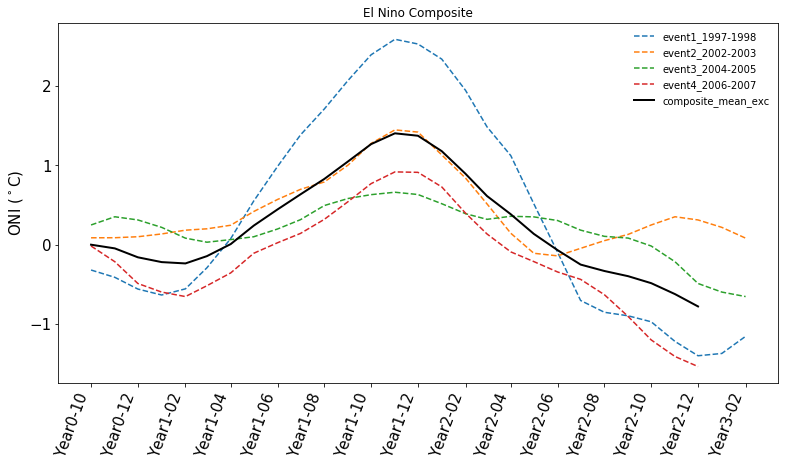

In [31]:
import importlib
import enso_composite
importlib.reload(enso_composite)

from enso_composite import elnino_composite

ds_oni_comp = elnino_composite(ds_oni.oni,syear,fyear,premon=13,postmon=15,period_type='maxval',exclude=[])

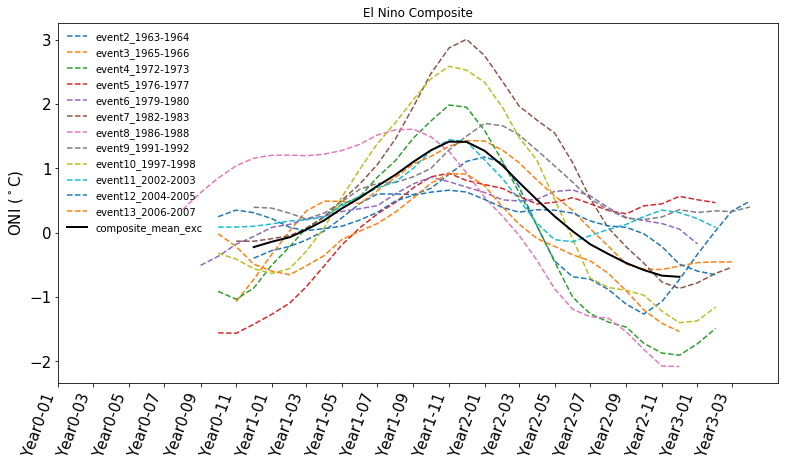

In [32]:
import importlib
import enso_composite
importlib.reload(enso_composite)

from enso_composite import elnino_composite

ds_oni_comp1 = elnino_composite(ds_oni.oni,syear1,fyear1,premon=13,postmon=15,period_type='maxval',exclude=[1])

In [33]:
ds_oni.oni

<xarray.DataArray 'oni' (time: 720)>
array([      nan,  1.309968,  1.371114, ..., -0.358217, -0.54235 ,       nan])
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2017-12-01
    month    (time) int64 ...

In [65]:
import importlib
import enso_composite
importlib.reload(enso_composite)
from enso_composite import proc_elnino_composite_maps

elninocomp_mlist = {}
elninocomp_mlist1 = {}
for nmodel,model in enumerate(Model_name):
    elninocomp_list = {}
    elninocomp_list1 = {}
    for nvar,var in enumerate(Model_varname):
        elninocomp_list[var] = proc_elnino_composite_maps(ds_oni.oni,
                                                        ds_model_mlist[model][var],
                                                        syear,
                                                        fyear,
                                                        premon=13,
                                                        postmon=15,
                                                        period_type='maxval',
                                                        exclude=[])
        elninocomp_list1[var] = proc_elnino_composite_maps(ds_oni.oni,
                                                        ds_model_mlist1[model][var],
                                                        syear1,
                                                        fyear1,
                                                        premon=13,
                                                        postmon=15,
                                                        period_type='maxval',
                                                        exclude=[1])
    elninocomp_mlist[model] = elninocomp_list
    elninocomp_mlist1[model] = elninocomp_list1

4
12
4
12
4
12
4
12
4
12
4
12
4
12
4
12


In [56]:
Obs_name = ['WESwind','CMEMS']
Obs_varname = [['tx','ty'],['adt']]
obs_elninocomp_mlist = {}
for nobs,obs in enumerate(Obs_name):
    obs_elninocomp_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_elninocomp_list[var] = proc_elnino_composite_maps(ds_oni.oni,
                                                        ds_obs_mlist[obs][var],
                                                        syear,
                                                        fyear,
                                                        premon=13,
                                                        postmon=15,
                                                        period_type='maxval',
                                                        exclude=[])
    obs_elninocomp_mlist[obs] = obs_elninocomp_list

5
5
5


In [67]:
Obs_name = ['WESwind']
Obs_varname = [['tx','ty']]
obs_elninocomp_mlist1 = {}
for nobs,obs in enumerate(Obs_name):
    obs_elninocomp_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_elninocomp_list[var] = proc_elnino_composite_maps(ds_oni.oni,
                                                        ds_obs_mlist1[obs][var],
                                                        syear1,
                                                        fyear1,
                                                        premon=13,
                                                        postmon=15,
                                                        period_type='maxval',
                                                        exclude=[1])
    obs_elninocomp_mlist1[obs] = obs_elninocomp_list

12
12


# Apply regridder

In [66]:
#### regridding elnino composite field 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            elninocomp_mlist[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](elninocomp_mlist[model][var])
            elninocomp_mlist[model][var]['x'] = da_model_standard.x.values
            elninocomp_mlist[model][var]['y'] = da_model_standard.y.values
            
            elninocomp_mlist1[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](elninocomp_mlist1[model][var])
            elninocomp_mlist1[model][var]['x'] = da_model_standard.x.values
            elninocomp_mlist1[model][var]['y'] = da_model_standard.y.values

model variable same as standard model variable


In [59]:
Obs_name = ['WESwind','CMEMS']
Obs_varname = [['tx','ty'],['adt']]
#### regridding elnino composite field 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_elninocomp_mlist[obs][var] = \
          regridder_mlist[obs]['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)](obs_elninocomp_mlist[obs][var])
        obs_elninocomp_mlist[obs][var]['x'] = da_model_standard.x.values
        obs_elninocomp_mlist[obs][var]['y'] = da_model_standard.y.values

In [68]:
Obs_name = ['WESwind']
Obs_varname = [['tx','ty']]
#### regridding elnino composite field 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_elninocomp_mlist1[obs][var] = \
          regridder_mlist[obs]['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)](obs_elninocomp_mlist1[obs][var])
        obs_elninocomp_mlist1[obs][var]['x'] = da_model_standard.x.values
        obs_elninocomp_mlist1[obs][var]['y'] = da_model_standard.y.values

# Derive Ekman upwelling/downwelling and wind stress curl

In [40]:
# import importlib
# import dynamical_balance2
# importlib.reload(dynamical_balance2)
# from dynamical_balance2 import curl_tau, ekman_pumping2

# obs_elninocomp_mlist['WESwind']['Ek_tx'],obs_elninocomp_mlist['WESwind']['Ek_ty'] = ekman_pumping2(
#                                                       obs_elninocomp_mlist['WESwind']['tx'].slope,
#                                                       obs_elninocomp_mlist['WESwind']['ty'].slope,
#                                                       eq_mask=True)
# obs_elninocomp_mlist['WESwind']['curl_tx'],obs_elninocomp_mlist['WESwind']['curl_ty'] = curl_tau(
#                                                obs_elninocomp_mlist['WESwind']['tx'].slope,
#                                                obs_elninocomp_mlist['WESwind']['ty'].slope)

# obs_elninocomp_mlist1['WESwind']['Ek_tx'],obs_elninocomp_mlist1['WESwind']['Ek_ty'] = ekman_pumping2(
#                                                       obs_elninocomp_mlist1['WESwind']['tx'].slope,
#                                                       obs_elninocomp_mlist1['WESwind']['ty'].slope,
#                                                       eq_mask=True)
# obs_elninocomp_mlist1['WESwind']['curl_tx'],obs_elninocomp_mlist1['WESwind']['curl_ty'] = curl_tau(
#                                                obs_elninocomp_mlist1['WESwind']['tx'].slope,
#                                                obs_elninocomp_mlist1['WESwind']['ty'].slope)

# for nmodel,model in enumerate(Model_name):
#     elninocomp_mlist[model]['Ek_tauuo'],elninocomp_mlist[model]['Ek_tauvo'] = ekman_pumping2(
#                                                       elninocomp_mlist[model]['tauuo'].slope,
#                                                       elninocomp_mlist[model]['tauvo'].slope,
#                                                       eq_mask=True)
#     elninocomp_mlist[model]['curl_tauuo'],elninocomp_mlist[model]['curl_tauvo'] = curl_tau(
#                                                elninocomp_mlist[model]['tauuo'].slope,
#                                                elninocomp_mlist[model]['tauvo'].slope)
    
#     elninocomp_mlist1[model]['Ek_tauuo'],elninocomp_mlist1[model]['Ek_tauvo'] = ekman_pumping2(
#                                                       elninocomp_mlist1[model]['tauuo'].slope,
#                                                       elninocomp_mlist1[model]['tauvo'].slope,
#                                                       eq_mask=True)
#     elninocomp_mlist1[model]['curl_tauuo'],elninocomp_mlist1[model]['curl_tauvo'] = curl_tau(
#                                                elninocomp_mlist1[model]['tauuo'].slope,
#                                                elninocomp_mlist1[model]['tauvo'].slope)

# Derive Ekman transport and Sverdrup transport

In [41]:
# import importlib
# import dynamical_balance2
# importlib.reload(dynamical_balance2)
# from dynamical_balance2 import sverdrup_transport, ekman_transport

# obs_elninocomp_mlist['WESwind']['Ek_tranx'],obs_elninocomp_mlist['WESwind']['Ek_trany'] = ekman_transport(
#                                                       obs_elninocomp_mlist['WESwind']['tx'].slope,
#                                                       obs_elninocomp_mlist['WESwind']['ty'].slope,
#                                                       eq_mask=True)

# obs_elninocomp_mlist['WESwind']['Sv_tranx'],obs_elninocomp_mlist['WESwind']['Sv_trany'],\
# obs_elninocomp_mlist['WESwind']['Sv_stream'] = sverdrup_transport(obs_elninocomp_mlist['WESwind']['tx'].slope*da_pacific,
#                                                                    obs_elninocomp_mlist['WESwind']['ty'].slope*da_pacific)


# obs_elninocomp_mlist1['WESwind']['Ek_tranx'],obs_elninocomp_mlist1['WESwind']['Ek_trany'] = ekman_transport(
#                                                       obs_elninocomp_mlist1['WESwind']['tx'].slope,
#                                                       obs_elninocomp_mlist1['WESwind']['ty'].slope,
#                                                       eq_mask=True)

# obs_elninocomp_mlist1['WESwind']['Sv_tranx'],obs_elninocomp_mlist1['WESwind']['Sv_trany'],\
# obs_elninocomp_mlist1['WESwind']['Sv_stream'] = sverdrup_transport(obs_elninocomp_mlist1['WESwind']['tx'].slope*da_pacific,
#                                                                    obs_elninocomp_mlist1['WESwind']['ty'].slope*da_pacific)

# for nmodel,model in enumerate(Model_name):
#     elninocomp_mlist[model]['Ek_tranx'],elninocomp_mlist[model]['Ek_trany'] = ekman_transport(
#                                                       elninocomp_mlist[model]['tauuo'].slope,
#                                                       elninocomp_mlist[model]['tauvo'].slope,
#                                                       eq_mask=True)
#     elninocomp_mlist[model]['Sv_tranx'],elninocomp_mlist[model]['Sv_trany'],\
#     elninocomp_mlist[model]['Sv_stream']= sverdrup_transport(elninocomp_mlist[model]['tauuo'].slope*da_pacific,
#                                                               elninocomp_mlist[model]['tauvo'].slope*da_pacific)
    
#     elninocomp_mlist1[model]['Ek_tranx'],elninocomp_mlist1[model]['Ek_trany'] = ekman_transport(
#                                                       elninocomp_mlist1[model]['tauuo'].slope,
#                                                       elninocomp_mlist1[model]['tauvo'].slope,
#                                                       eq_mask=True)
#     elninocomp_mlist1[model]['Sv_tranx'],elninocomp_mlist1[model]['Sv_trany'],\
#     elninocomp_mlist1[model]['Sv_stream']= sverdrup_transport(elninocomp_mlist1[model]['tauuo'].slope*da_pacific,
#                                                               elninocomp_mlist1[model]['tauvo'].slope*da_pacific)

# Plotting 

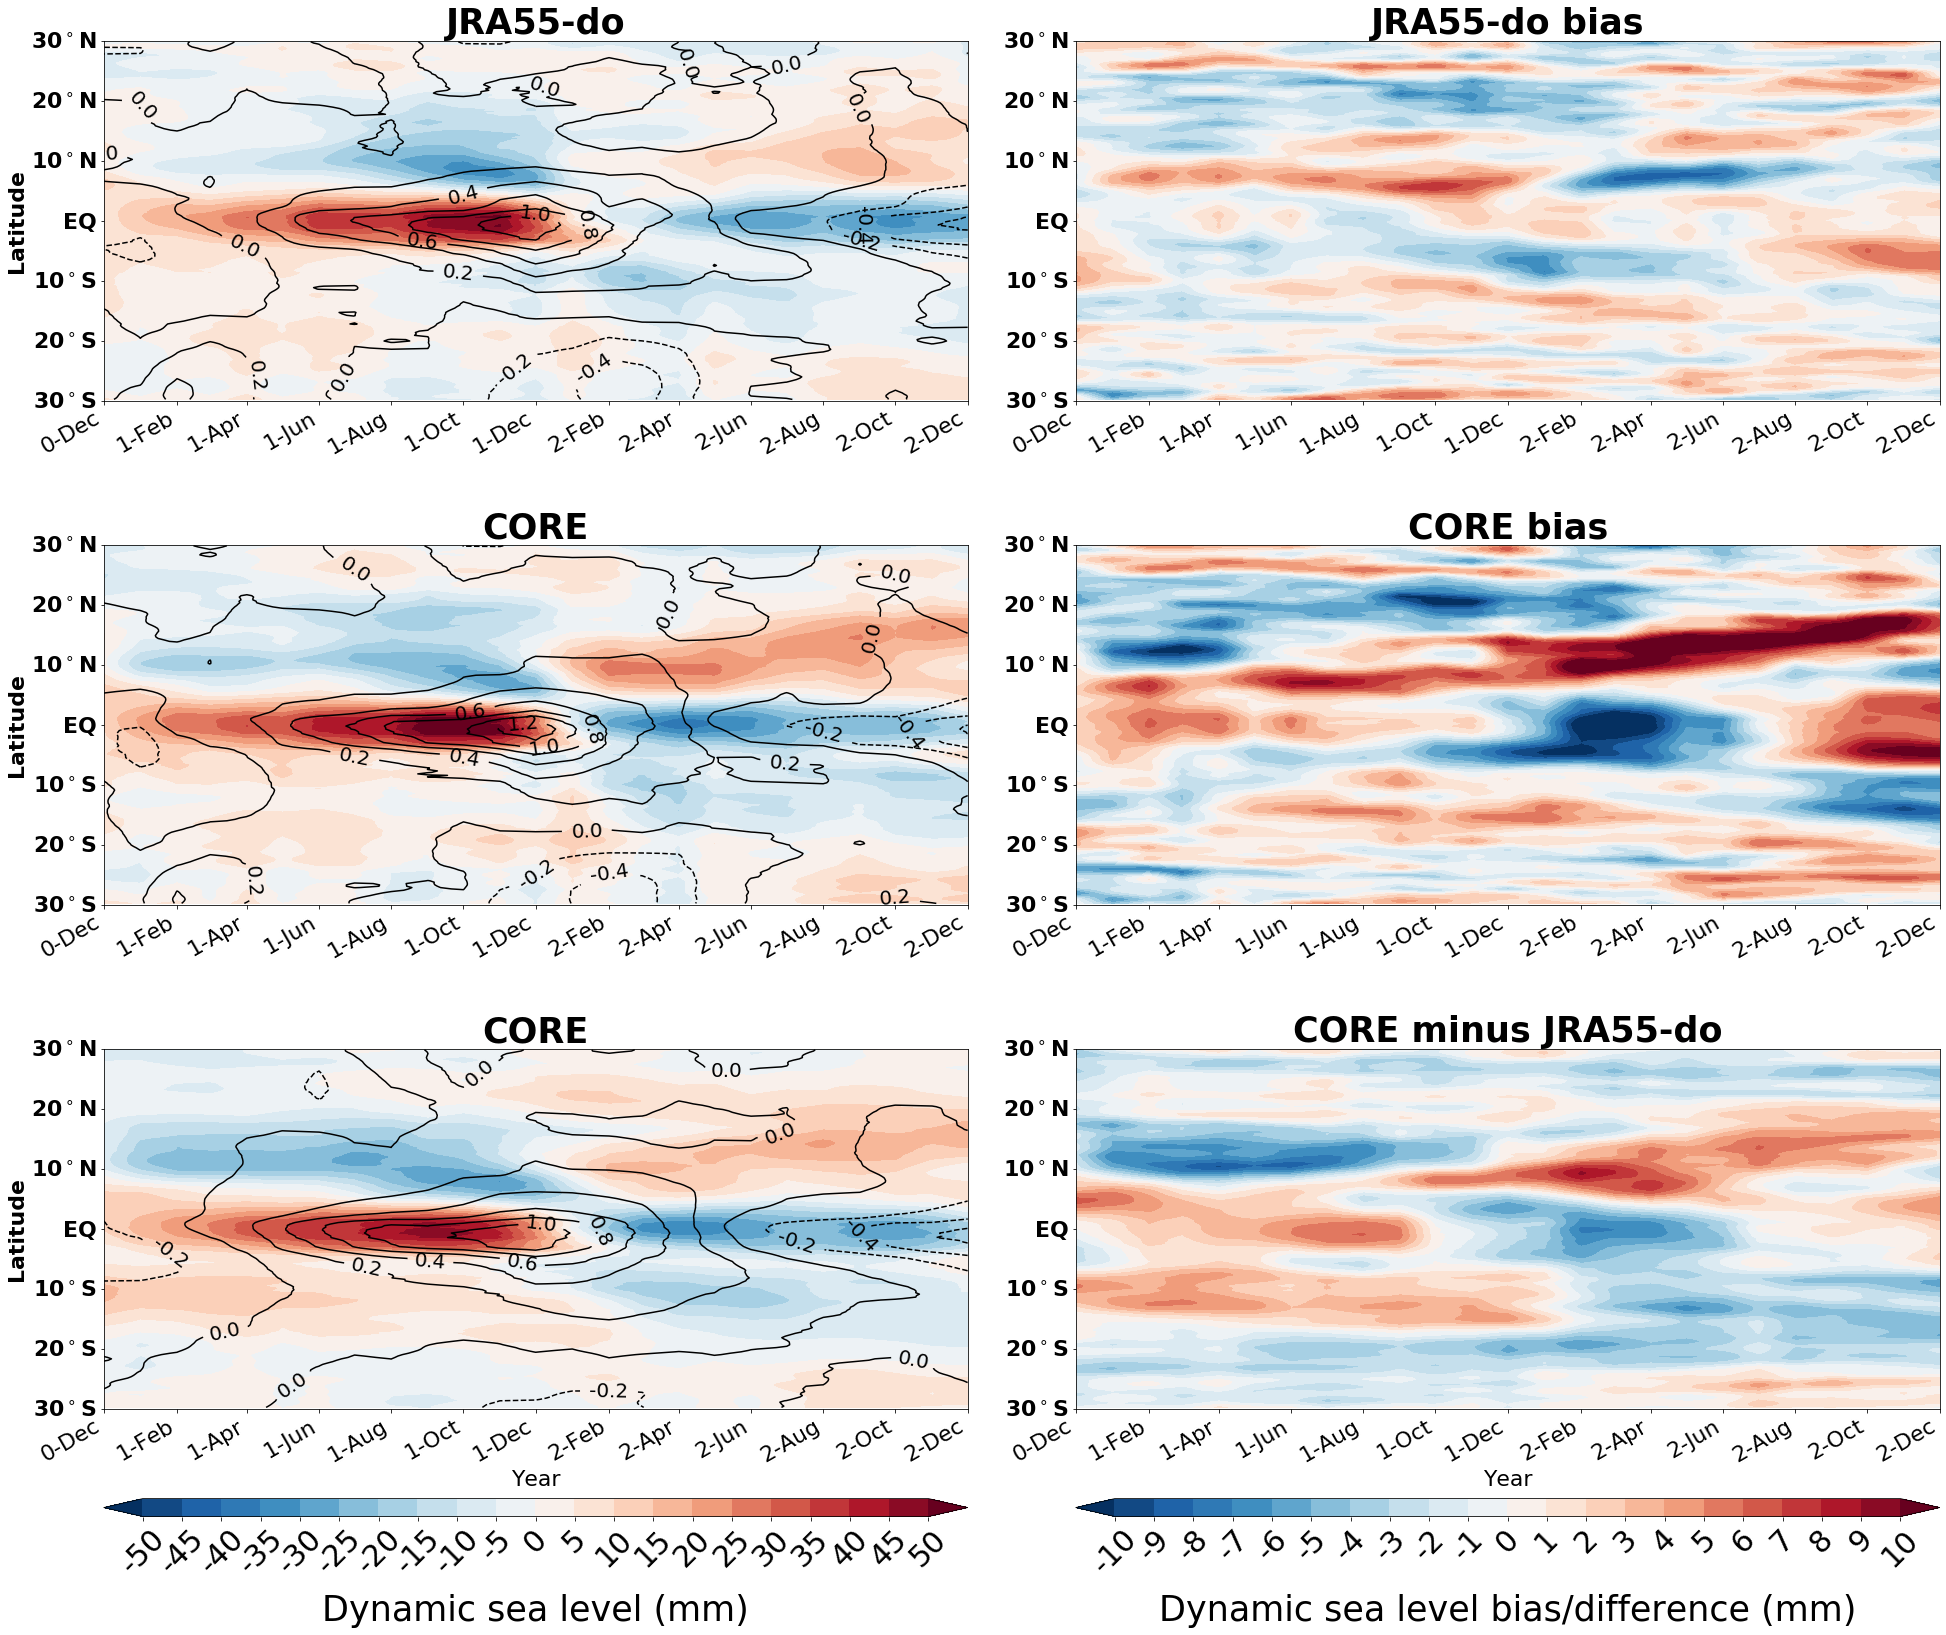

In [78]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
devy = 1.4
# setting regional boundary
lat_range = np.array([-30,30])
lat_label = np.array([-30,-20,-10,0,10,20,30])

for nmodel, model in enumerate(Model_name):

    ax2 = fig.add_axes([0,0-nmodel*devy,1,1])
    var2 = 'zos'
    var3 = 'tos'
    level = np.linspace(-0.05,0.05,21)
    tlevel = np.linspace(-2,2,21)
    biaslevel = np.linspace(-0.01,0.01,21)
    im = (elninocomp_mlist[model][var2]*da_pacific).mean(dim='x')\
                          .plot.contourf(x='time',
                                         y='y',
                                         ax=ax2,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')
    cs = (elninocomp_mlist[model][var3]*da_pacific).mean(dim='x')\
                          .plot.contour(x='time',
                                         y='y',
                                         ax=ax2,
                                         levels=tlevel,
                                         colors='k',
                                         extend='both')
    ax2.clabel(cs, inline=1, fontsize=20,fmt='%1.1f')
    cb=im.colorbar
    cb.remove()
#     if nmodel == len(Model_name)-1:
#         cbaxes=fig.add_axes([0.05,-0.3-nmodel*devy,1.6, 0.05])
#         cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
#         cbar.set_ticks(level)
#         cbar.set_ticklabels(["%0.0f"%(n*1000) for n in level])  
#         cbar.ax.tick_params(labelsize=22,rotation=60) 
#         cbar.set_label(label='(mm)',size=22, labelpad=15)
    ax2.set_title('%s'%(Model_legend_name[nmodel]), color='black', weight='bold',size=30)
    
    ax3 = fig.add_axes([0.9,0-nmodel*devy,1,1])
    var2 = 'zos'
    var4 = 'adt'
    im = (elninocomp_mlist[model][var2]-obs_elninocomp_mlist['CMEMS'][var4])\
            .mean(dim='x').plot.contourf(x='time',
                                         y='y',
                                         ax=ax3,
                                         levels=biaslevel,
                                         cmap='RdBu_r',
                                         extend='both')
    cb=im.colorbar
    cb.remove()
    

    ax2.set_yticks(lat_label)
    ax2.set_yticklabels(['30$^\circ$S','20$^\circ$S','10$^\circ$S','EQ','10$^\circ$N','20$^\circ$N','30$^\circ$N'],
                        color='black', weight='bold',size=22)
    ax2.set_xticks(ds_oni_comp1.time.values[11:-4:2])
    mon_label = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    ax2.set_xticklabels(["%0.1i-%s"%(date.year,mon_label[np.int(date.month)-1]) for date in ds_oni_comp1.cftime.values[11:-4:2]],size=22)
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlim([ds_oni_comp.time.values[2],ds_oni_comp.time.values[-3]])
    ax2.set_xlabel('',size=22)
    ax2.set_ylabel('Latitude',size=22, weight='bold')
    ax2.set_title('%s'%(Model_legend_name[nmodel]), color='black', weight='bold',size=35)
    
    ax3.set_yticks(lat_label)
    ax3.set_yticklabels(['30$^\circ$S','20$^\circ$S','10$^\circ$S','EQ','10$^\circ$N','20$^\circ$N','30$^\circ$N'],
                        color='black', weight='bold',size=22)
    ax3.set_xticks(ds_oni_comp1.time.values[11:-4:2])
    mon_label = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    ax3.set_xticklabels(["%0.1i-%s"%(date.year,mon_label[np.int(date.month)-1]) for date in ds_oni_comp1.cftime.values[11:-4:2]],size=22)
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax3.set_xlabel('',size=22)
    ax3.set_ylabel('',size=22)
    ax3.set_xlim([ds_oni_comp.time.values[2],ds_oni_comp.time.values[-3]])
    ax3.set_title('%s bias'%(Model_legend_name[nmodel]), color='black', weight='bold',size=35) 

    
#######################################################
ax2 = fig.add_axes([0,0-(nmodel+1)*devy,1,1])
var2 = 'zos'
var3 = 'tos'
im = (elninocomp_mlist1['CORE'][var2]*da_pacific).mean(dim='x')\
                      .plot.contourf(x='time',
                                     y='y',
                                     ax=ax2,
                                     levels=level,
                                     cmap='RdBu_r',
                                     extend='both')

cs = (elninocomp_mlist1['CORE'][var3]*da_pacific).mean(dim='x')\
                      .plot.contour(x='time',
                                     y='y',
                                     ax=ax2,
                                     levels=tlevel,
                                     colors='k',
                                     extend='both')
ax2.clabel(cs, inline=1, fontsize=20,fmt='%1.1f')

cb=im.colorbar
cb.remove()

cbaxes=fig.add_axes([0,-0.3-(nmodel+1)*devy,0.8, 0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n*1000) for n in level])  
cbar.ax.tick_params(labelsize=30,rotation=45) 
cbar.set_label(label='Dynamic sea level (mm)',size=35, labelpad=15)


cbaxes=fig.add_axes([0.1+0.8,-0.3-(nmodel+1)*devy,0.8, 0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n*1000) for n in biaslevel])  
cbar.ax.tick_params(labelsize=30,rotation=45) 
cbar.set_label(label='Dynamic sea level bias/difference (mm)',size=35, labelpad=15)

ax3 = fig.add_axes([0.9,0-(nmodel+1)*devy,1,1])
var2 = 'zos'
var4 = 'zos'
im = (elninocomp_mlist1['CORE'][var2]-elninocomp_mlist1['JRA'][var4])\
        .mean(dim='x').plot.contourf(x='time',
                                     y='y',
                                     ax=ax3,
                                     levels=biaslevel,
                                     cmap='RdBu_r',
                                     extend='both')
cb=im.colorbar
cb.remove()


ax2.set_yticks(lat_label)
ax2.set_yticklabels(['30$^\circ$S','20$^\circ$S','10$^\circ$S','EQ','10$^\circ$N','20$^\circ$N','30$^\circ$N'],
                    color='black', weight='bold',size=22)
ax2.set_xticks(ds_oni_comp1.time.values[11:-4:2])
mon_label = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
ax2.set_xticklabels(["%0.1i-%s"%(date.year,mon_label[np.int(date.month)-1]) for date in ds_oni_comp1.cftime.values[11:-4:2]],size=22)
# ax2.set_xticks(ds_oni_comp1.time.values[11:-4:2])
# ax2.set_xticklabels(["%0.1i-%0.2i"%(date.year,date.month) for date in ds_oni_comp1.cftime.values[11:-4:2]],size=22)
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlim([ds_oni_comp1.time.values[11],ds_oni_comp1.time.values[-5]])
ax2.set_xlabel('Year',size=22)
ax2.set_ylabel('Latitude',size=22, weight='bold')
ax2.set_title('CORE', color='black', weight='bold',size=35)


ax3.set_yticks(lat_label)
ax3.set_yticklabels(['30$^\circ$S','20$^\circ$S','10$^\circ$S','EQ','10$^\circ$N','20$^\circ$N','30$^\circ$N'],
                    color='black', weight='bold',size=22)

ax3.set_xticks(ds_oni_comp1.time.values[11:-4:2])
mon_label = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
ax3.set_xticklabels(["%0.1i-%s"%(date.year,mon_label[np.int(date.month)-1]) for date in ds_oni_comp1.cftime.values[11:-4:2]],size=22)

# ax3.set_xticks(ds_oni_comp1.time.values[11:-4:2])
# ax3.set_xticklabels(["%0.1i-%0.2i"%(date.year,date.month) for date in ds_oni_comp1.cftime.values[11:-4:2]],size=22)
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax3.set_xlabel('Year',size=22)
ax3.set_ylabel('',size=22)
ax3.set_xlim([ds_oni_comp1.time.values[11],ds_oni_comp1.time.values[-5]])
ax3.set_title('CORE minus JRA55-do', color='black', weight='bold',size=35)


fig.savefig('../figure/figure17.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

# 1958-2007

In [82]:
elninocomp_mlist1['CORE']['zos'].isel(time=[ 2, 3, 4, 5, 6, 7])

<xarray.DataArray (time: 6, y: 251, x: 1440)>
array([[[ 0.00477 ,  0.003698, ...,  0.005045,  0.005356],
        [ 0.005802,  0.004437, ...,  0.006544,  0.006672],
        ...,
        [ 0.      ,  0.      , ...,       nan,       nan],
        [ 0.      ,  0.      , ...,       nan,       nan]],

       [[-0.003103, -0.003526, ..., -0.002249, -0.002717],
        [-0.00247 , -0.00326 , ..., -0.001157, -0.001776],
        ...,
        [ 0.      ,  0.      , ...,       nan,       nan],
        [ 0.      ,  0.      , ...,       nan,       nan]],

       ...,

       [[-0.003916, -0.002478, ..., -0.007471, -0.005744],
        [-0.00625 , -0.004886, ..., -0.008783, -0.007718],
        ...,
        [ 0.      ,  0.      , ...,       nan,       nan],
        [ 0.      ,  0.      , ...,       nan,       nan]],

       [[-0.002162, -0.001008, ..., -0.006229, -0.004148],
        [-0.005403, -0.004056, ..., -0.008802, -0.007255],
        ...,
        [ 0.      ,  0.      , ...,       nan,       nan]

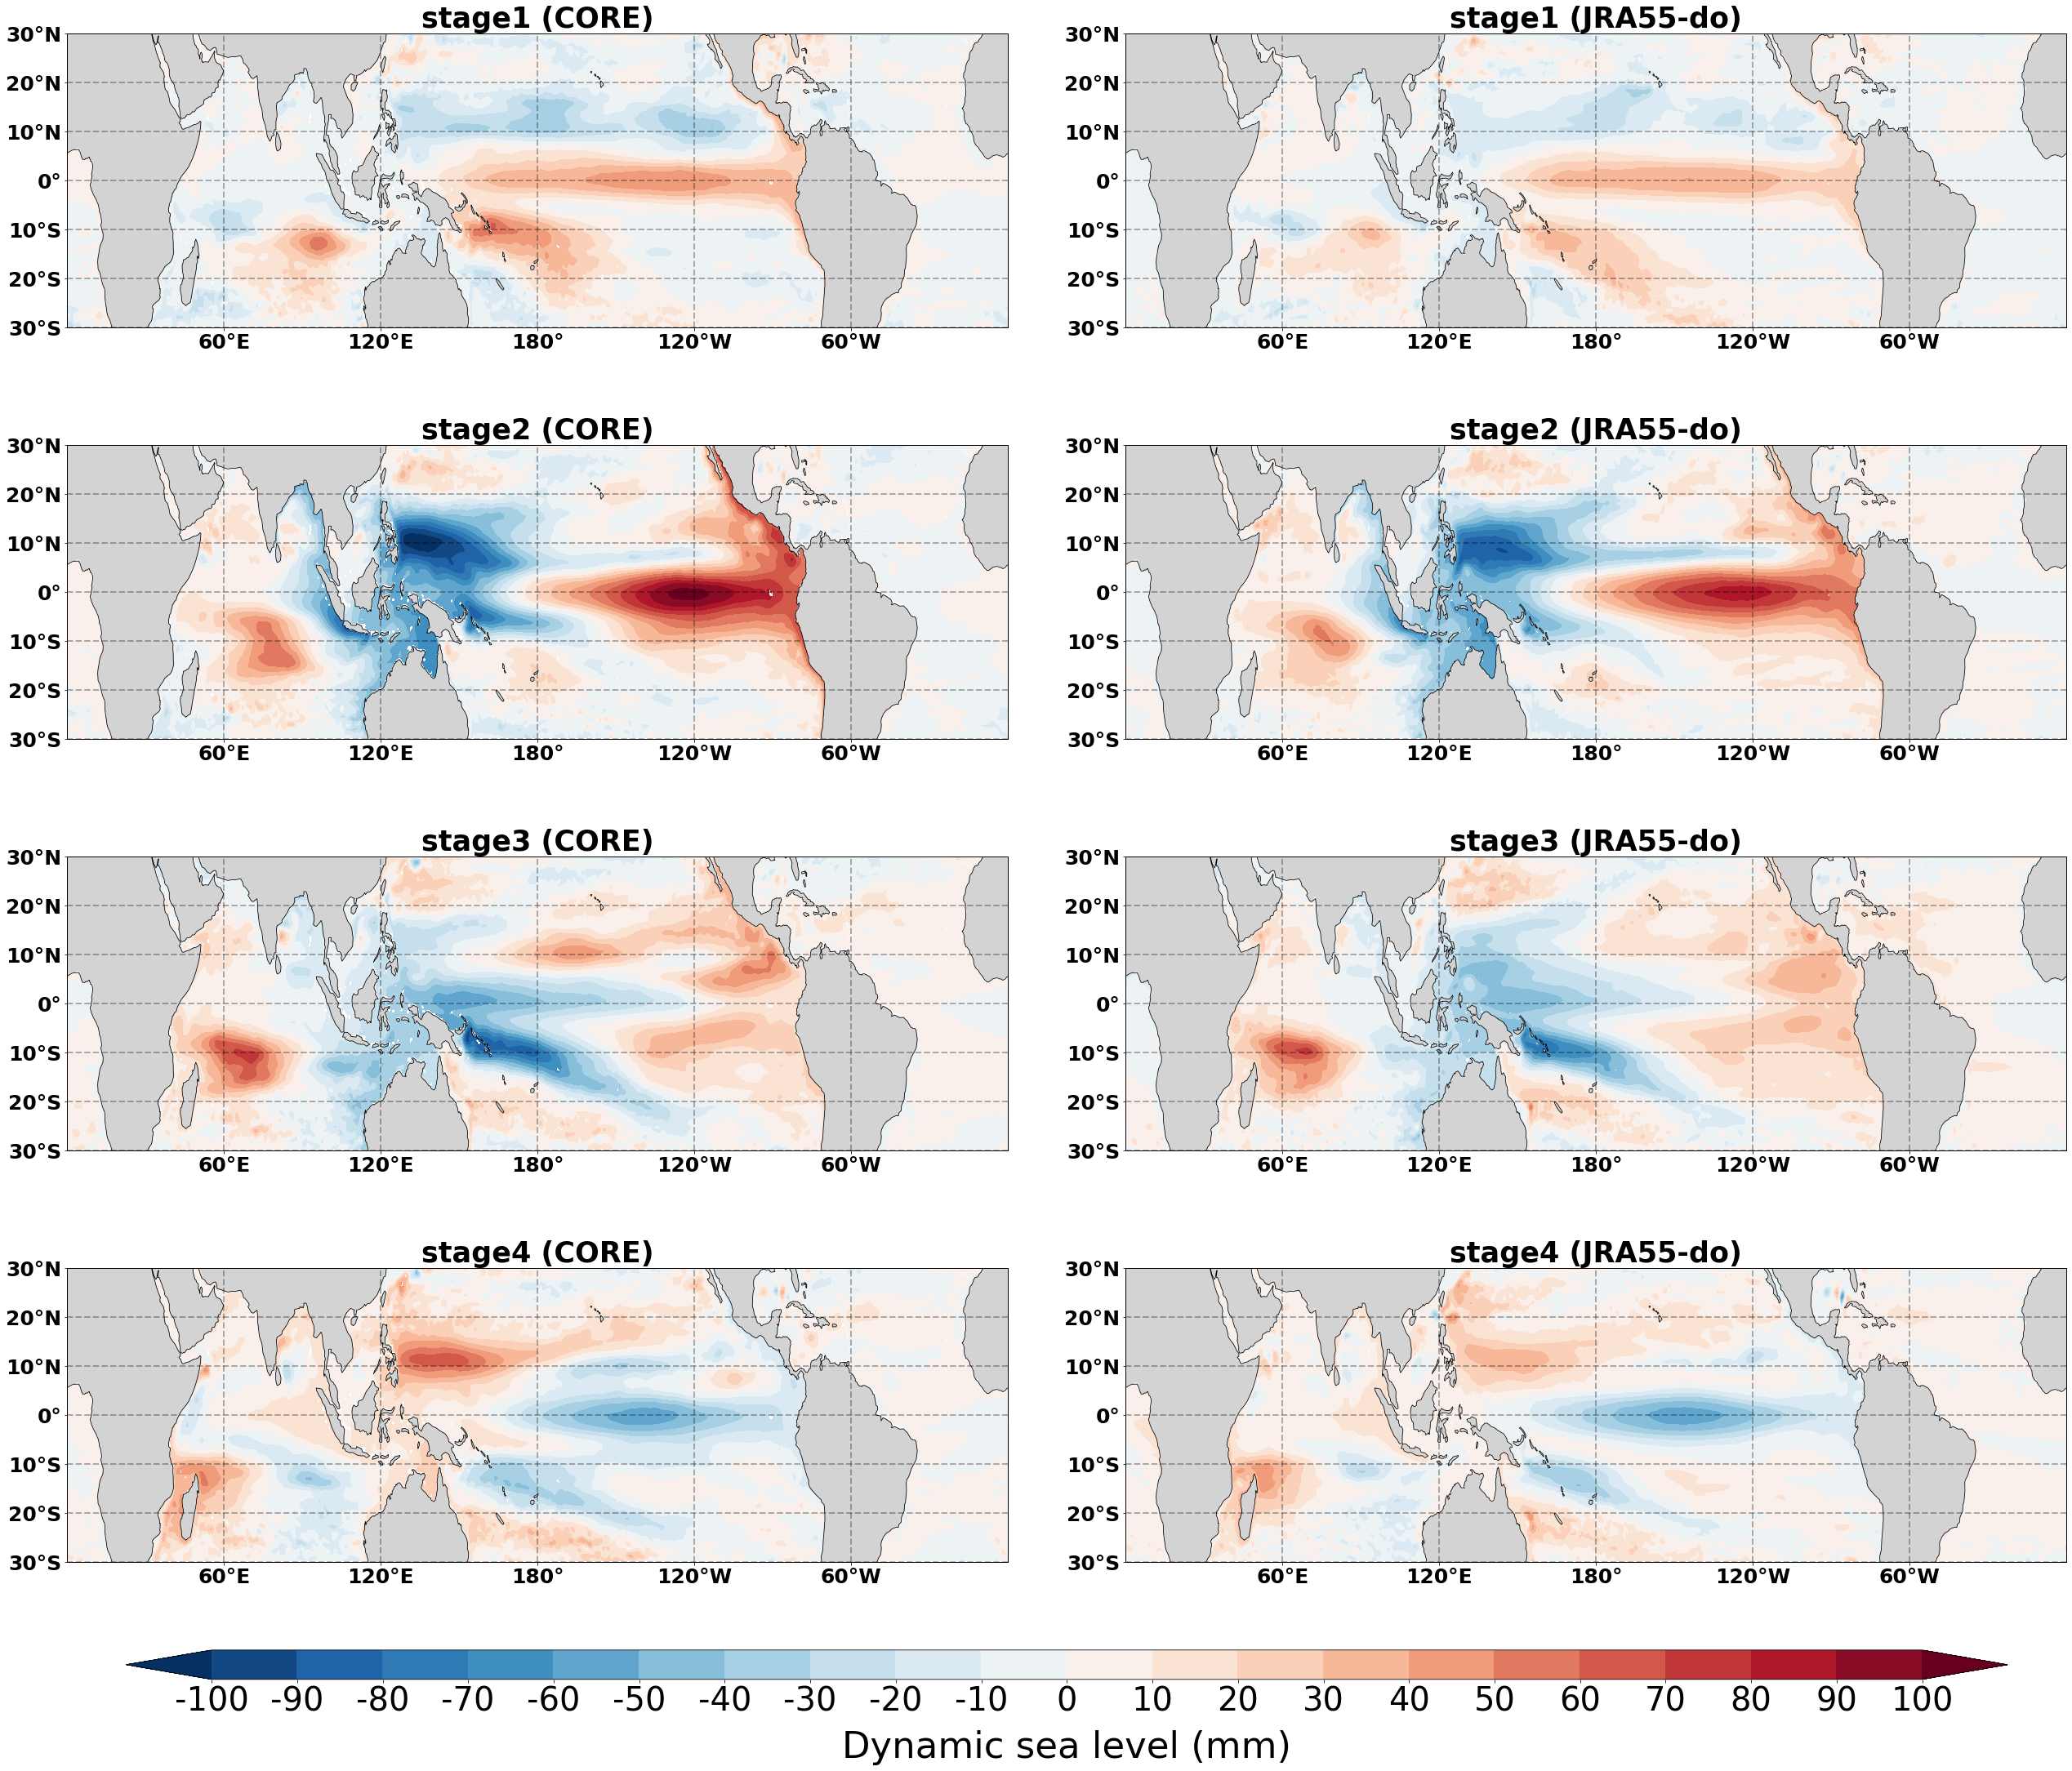

In [76]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(2,figsize=(20,10))
devy = 0.7

time_range = [[ 2, 3, 4, 5, 6, 7],
              [ 8, 9,10,11,12,13],
              [13,14,15,16,17,18],
              [19,20,21,22,23,24]]

time_range_name = ["stage1","stage2","stage3","stage4"]

for ntrange,trange in enumerate(time_range) :

    #### plotting
    level=np.linspace(-0.1, 0.1, 21)

    ax2=fig.add_axes([0,0-ntrange*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
    im=(elninocomp_mlist1['CORE']['zos']*elninocomp_mlist1['CORE']['zos']/elninocomp_mlist1['CORE']['zos'])\
                 .isel(time=trange).mean('time')\
                 .plot.contourf(x='lon',y='lat',
                                ax=ax2, levels=level, 
                                extend='both', cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0.))
    cb=im.colorbar
    cb.remove()

    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([ 60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([ 60,120,180,-120,-60], color='black', weight='bold',size=25)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=25)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s (%s)'%(time_range_name[ntrange],'CORE'),
                  color='black', weight='bold',size=35)
    ax2.set_aspect('auto')
    ax2=None


    #### plotting
    ax2=fig.add_axes([0+0.9,0-ntrange*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))

    im=(elninocomp_mlist1['JRA']['zos'])\
                 .isel(time=trange).mean('time')\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.set_title('%s (%s)'%(time_range_name[ntrange],'JRA55-do'), 
                  color='black', weight='bold',size=35)

    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=25)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=25)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_aspect('auto')

    

cbaxes=fig.add_axes([0.05,0-ntrange*devy-0.2,1.6,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n*1000) for n in level]) # 
cbar.ax.tick_params(labelsize=40,rotation=0) 
cbar.set_label(label='Dynamic sea level (mm)',size=45, labelpad=15)

fig.savefig('../figure/figure18.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

# 1993-2007

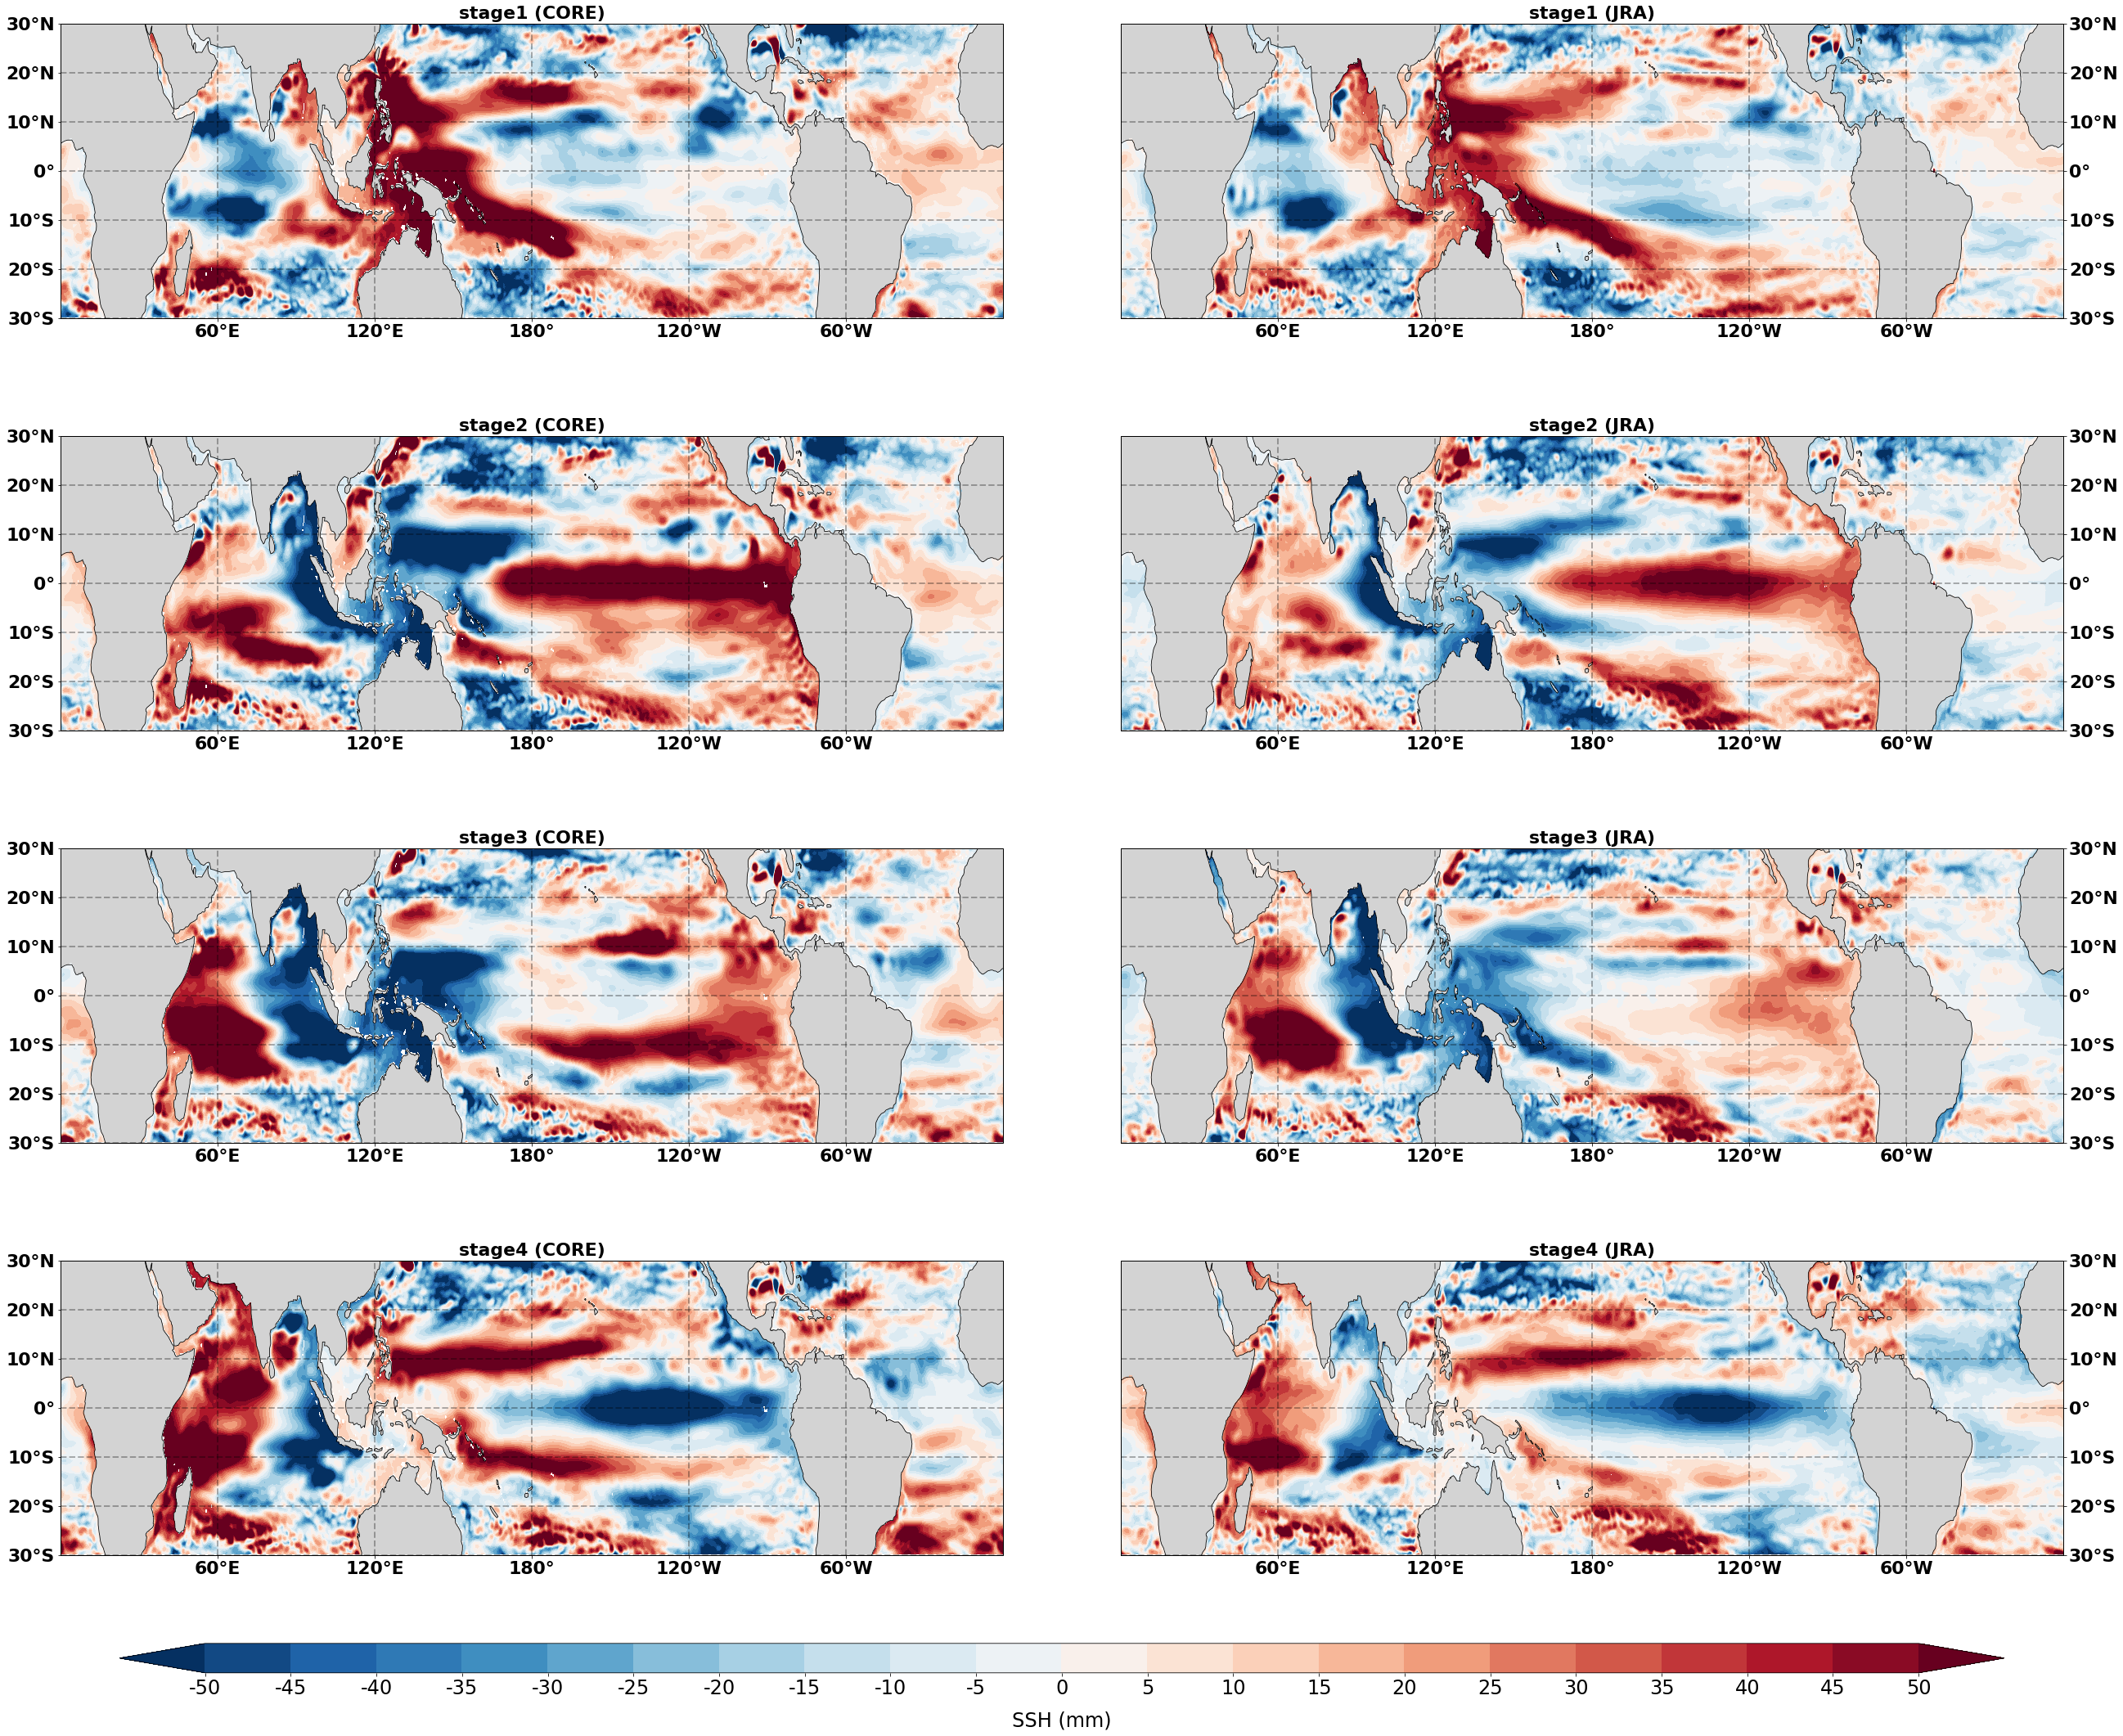

In [44]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7

time_range = [[ 2, 3, 4, 5, 6, 7],
              [ 8, 9,10,11,12,13],
              [13,14,15,16,17,18],
              [19,20,21,22,23,24]]

time_range_name = ["stage1","stage2","stage3","stage4"]

for ntrange,trange in enumerate(time_range) :

    #### plotting
    level=np.linspace(-0.05, 0.05, 21)

    ax2=fig.add_axes([0,0-ntrange*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
    im=(elninocomp_mlist['CORE']['zos']*elninocomp_mlist['CORE']['zos']/elninocomp_mlist['CORE']['zos'])\
                 .isel(time=trange).mean('time')\
                 .plot.contourf(x='lon',y='lat',
                                ax=ax2, levels=level, 
                                extend='both', cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0.))
    cb=im.colorbar
    cb.remove()

    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([ 60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([ 60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s (%s)'%(time_range_name[ntrange],'CORE'),
                  color='black', weight='bold',size=22)
    ax2.set_aspect('auto')
    ax2=None


    #### plotting
    ax2=fig.add_axes([0+0.9,0-ntrange*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))

    im=(elninocomp_mlist['JRA']['zos']*elninocomp_mlist['JRA']['zos']/elninocomp_mlist['JRA']['zos'])\
                 .isel(time=trange).mean('time')\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.set_title('%s (%s)'%(time_range_name[ntrange],'JRA'), 
                  color='black', weight='bold',size=22)

    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_right()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_aspect('auto')

    

cbaxes=fig.add_axes([0.05,0-ntrange*devy-0.2,1.6,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n*1000) for n in level]) # 
cbar.ax.tick_params(labelsize=24,rotation=0) 
cbar.set_label(label='SSH (mm)',size=24, labelpad=15)

fig.savefig('../figure/figure18_1.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

# obs

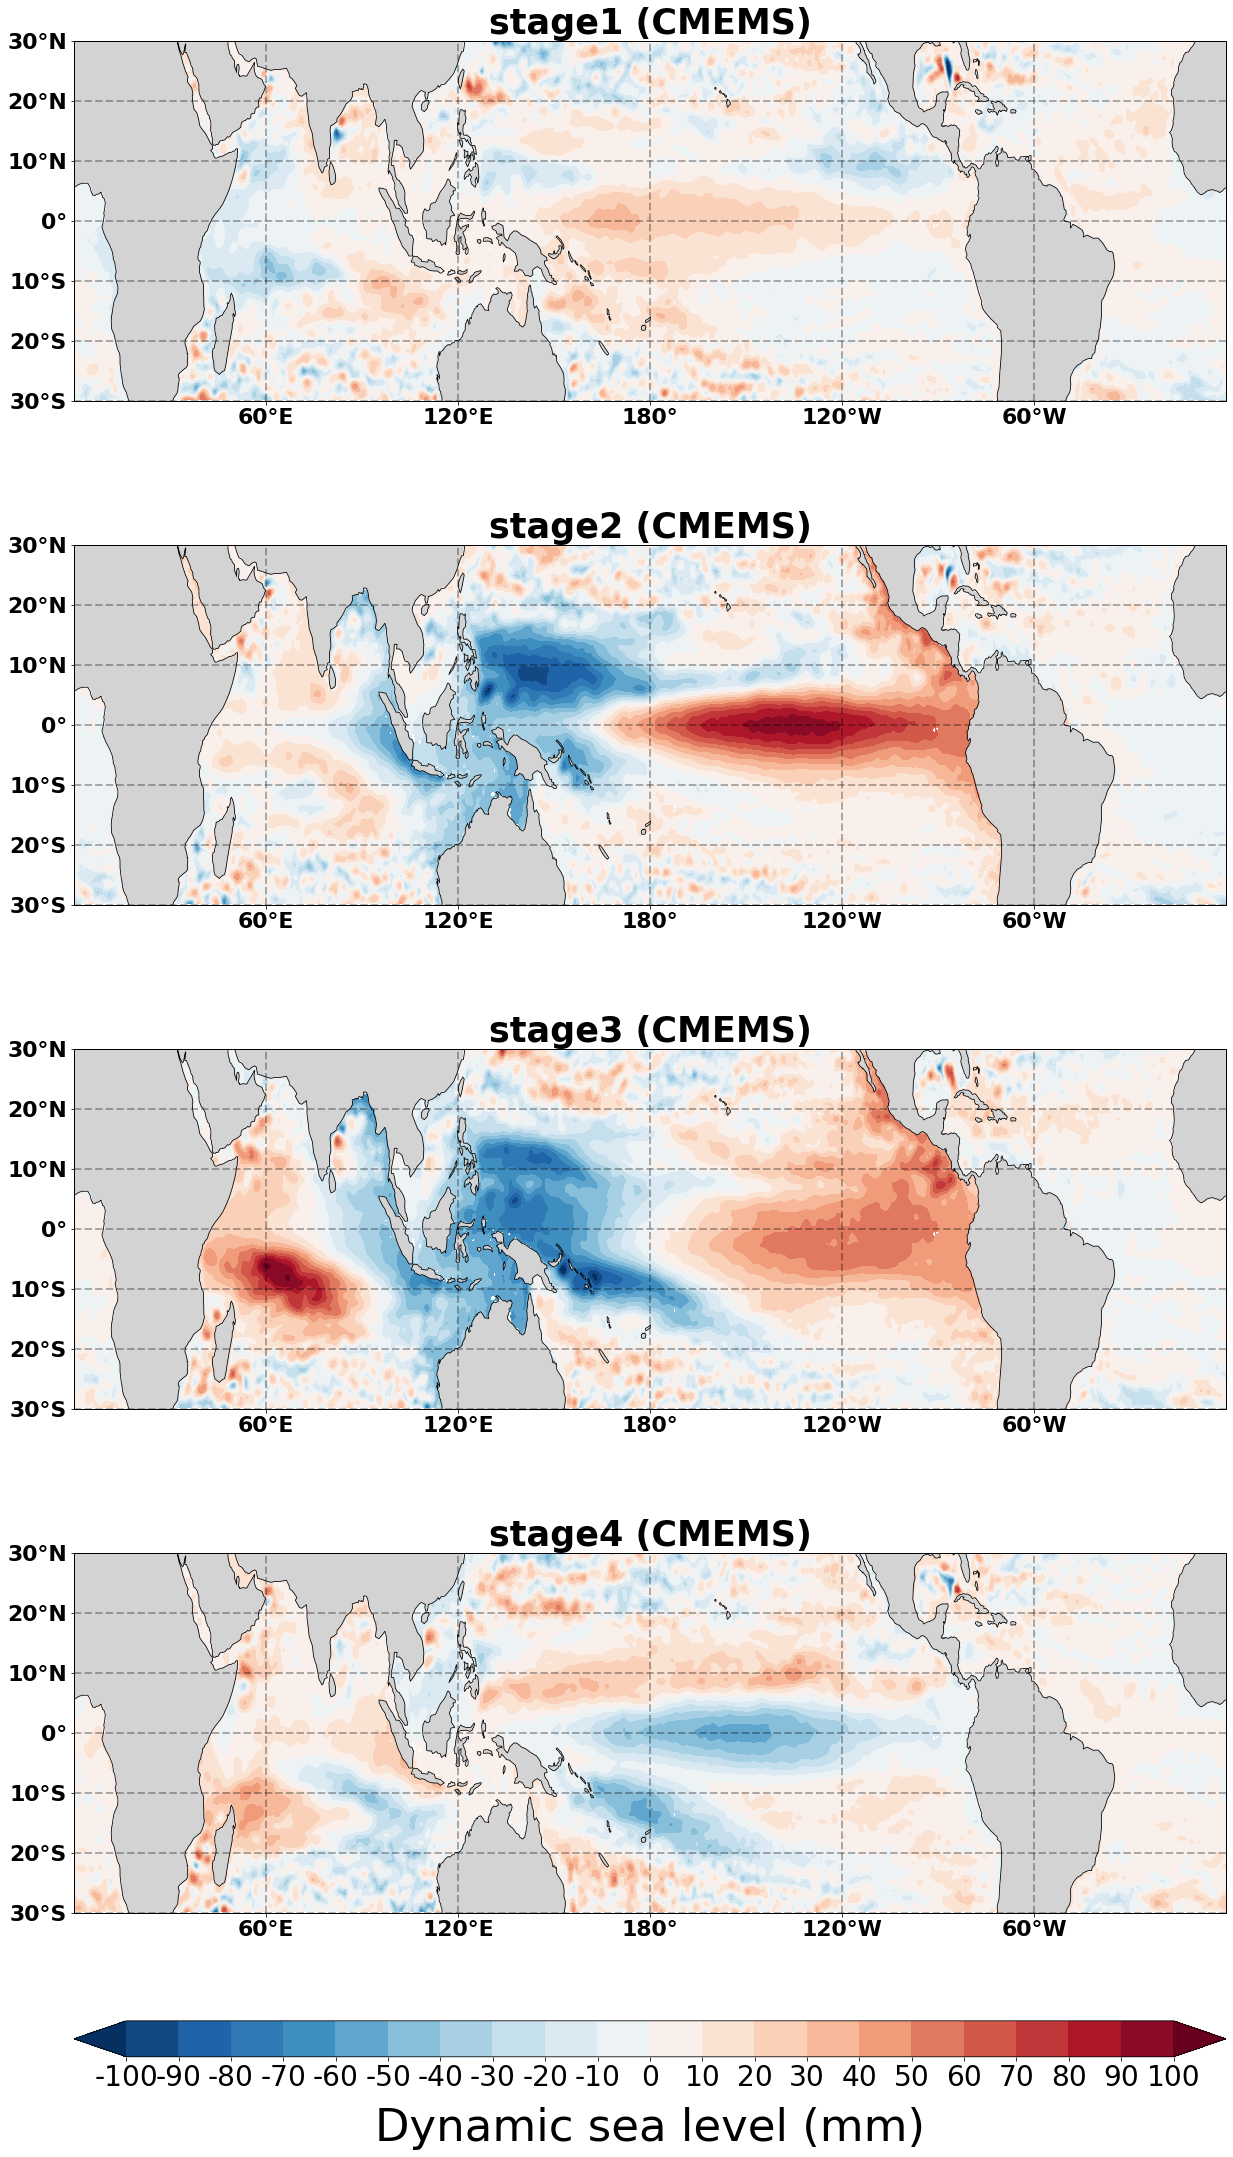

In [77]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7

time_range = [[ 2, 3, 4, 5, 6, 7],
              [ 8, 9,10,11,12,13],
              [13,14,15,16,17,18],
              [19,20,21,22,23,24]]

time_range_name = ["stage1","stage2","stage3","stage4"]

for ntrange,trange in enumerate(time_range) :

    #### plotting
    level=np.linspace(-0.1, 0.1, 21)

    ax2=fig.add_axes([0,0-ntrange*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
    im=(obs_elninocomp_mlist['CMEMS']['adt'])\
                 .isel(time=trange).mean('time')\
                 .plot.contourf(x='lon',y='lat',
                                ax=ax2, levels=level, 
                                extend='both', cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0.))
    cb=im.colorbar
    cb.remove()

    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([ 60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([ 60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s (%s)'%(time_range_name[ntrange],'CMEMS'),
                  color='black', weight='bold',size=35)
    ax2.set_aspect('auto')
    ax2=None

cbaxes=fig.add_axes([0.0,0-ntrange*devy-0.2,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n*1000) for n in level]) # 
cbar.ax.tick_params(labelsize=28,rotation=0) 
cbar.set_label(label='Dynamic sea level (mm)',size=45, labelpad=15)

fig.savefig('../figure/figure19.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)